<h1 align="center">12-1 Momentum Strategy, Implementation and Enhancements</h1> 

**Context**:

In physics, momentum refers to the quantity of motion that an object has. In finance, momentum describes the rate of change of returns of an underlying asset. Therefore, momentum trading is an investing style where an investor buys and sells stocks based on recent price trends. The idea is that if there is enough force behind a price move, the price will continue to move in the same direction, either on the upside (highest momentum) or the downside (lowest momentum). Momentum trading relies on a time-tested virtuous loop. When a stock reaches a higher price, it attracts more attention from traders and investors, which pushes its price even higher. This continues until a large number of sellers enter the market – for example, due to a change in company fundamentals based on quarterly earnings updates. Once enough sellers take over, the momentum changes direction and will force the stock price lower.

**Momentum 12-1 in practical terms**: 
- When a stock performed well for the last 12 months, it implies that the stock has good 12-month momentum. **Most recent return is excluded from the momentum calculation to remove any short-term reversal effects** (e.g. explains the '12-1' strategy). The expectation for a stock with positive momentum is that this momentum will continue onto the 13th month as well, and therefore the stock will continue to rise. On the contrary, when a stock performed poorly for the last 12 months, it is expected that the negative momentum will continue onto the 13th month, and therefore the stock will continue to fall.
- Therefore, for a 12-1 monthly momentum strategy, momentum is calculated based on 11 data points, as last month's return is not considered to remove short-term reversal effects.
- **Momentum naive strategy**: once the momentum stocks are identified, the are bought / shorted in in equal proportions (e.g same weight allocation across all stocks part of the strategy)
- Traditional momentum strategy is to **go long the stocks with highest (strongest positive) momentum and short the stocks with lowest (strongest negative) momentum**.

**Objective**
1. Implementation of a long/short 12-1 momentum strategy based on monthly returns.
2. Enhancements proposals to improve the return over risk ratio of the initial long/short 12-1 momentum strategy.

**Data**

Monthly returns for all stocks included in the MSCI World Index from 31 January 1995 to 31 October 2021.

**Organisation**

1. Section 1: Data pre-processing
2. Section 2: 12-1 Long/Short momentum strategy implementation and backtest
3. Section 3: Strategy enhancements for a better return over risk ratio
    - Half-momentum, half-contrarian strategy
    - Combination of 12-1 and 6-1 momentum stocks
    - 12-1 momentum strategy with risk-adjusted returns
    - Trend validation to detect overbought/oversold markets
    - HRP portfolio optimization, moving from naive to efficient weight allocation

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
from numpy import sqrt
from numpy.linalg import multi_dot
import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import FormatStrFormatter
from scipy import stats
from scipy.stats import linregress
import scipy.cluster.hierarchy as sch
from tabulate import tabulate

# Modern Portfolio Theory
import scipy.optimize as sco
# Hierarchical Risk Parity Portfolio optimization, see 'https://riskfolio-lib.readthedocs.io/en/latest/install.html' for dependecies
import riskfolio as rp

# Data pre-processing

We start by downloading the monthly return data, and check the date format.

In [1104]:
# Load MSCI World Index data
MSCI = pd.read_excel('data/Case_dataset.xlsx', index_col=0)
# Check the date format
print(MSCI.columns)

Int64Index([19950131, 19950228, 19950331, 19950430, 19950531, 19950630,
            19950731, 19950831, 19950930, 19951031,
            ...
            20210131, 20210228, 20210331, 20210430, 20210531, 20210630,
            20210731, 20210831, 20210930, 20211031],
           dtype='int64', length=322)


For good practice and plotting perspectives, we transform it the date string to a datetime format. We define **df** as the table of monthly returns for all stocks included in the MSCI World Index from 31 January 1995 to 31 October 2021.

In [1105]:
MSCI_dates = pd.to_datetime(MSCI.columns, format='%Y%m%d').strftime("%Y-%m-%d")
MSCI.columns = MSCI_dates
df = MSCI.T
df.index = pd.to_datetime(df.index)
df

,1,2,3,4,5,6,7,8,9,10,...,4343,4344,4345,4346,4347,4348,4349,4350,4351,4352
1995-01-31,NaN,-0.134557,NaN,0.001650,0.008708,NaN,-0.038563,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-28,NaN,0.020395,NaN,0.234353,0.203593,NaN,0.051244,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-31,NaN,NaN,NaN,0.111926,-0.080125,NaN,-0.120862,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-30,NaN,NaN,NaN,-0.017870,-0.007260,NaN,-0.085037,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-31,NaN,NaN,NaN,-0.018384,-0.047814,NaN,0.121458,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30,0.137212,NaN,NaN,NaN,NaN,NaN,NaN,0.043722,NaN,NaN,...,NaN,NaN,0.124309,0.043471,0.179827,NaN,NaN,NaN,NaN,NaN
2021-07-31,-0.080143,NaN,NaN,NaN,NaN,NaN,NaN,-0.011333,NaN,NaN,...,0.032097,NaN,0.002103,0.099016,-0.176335,NaN,NaN,NaN,NaN,NaN
2021-08-31,-0.051885,NaN,NaN,NaN,NaN,NaN,NaN,-0.003030,NaN,NaN,...,0.099722,NaN,0.583391,0.150567,0.218762,NaN,NaN,NaN,NaN,NaN
2021-09-30,-0.121794,NaN,NaN,NaN,NaN,NaN,NaN,-0.050879,NaN,NaN,...,-0.023746,NaN,-0.098518,0.012131,-0.070384,NaN,NaN,NaN,NaN,NaN


As first conclusion:
- Dataset is comprised of 322 monthly returns, from 31 January 1995 to 31 October 2021.
- 4,352 stocks were part of the MSCI World Index for that specific period.

# 12-1 Momentum strategy

## Calculation of momentum

As mentioned in the introduction, the momentum of a 12-1 momentum strategy is calculated based on 11 data points, as the most recent return is not considered in the momentum calculation to remove any short-term reversal effects. Said differently, **we can define the 12-1 momentum return as a 12-month cumulative return excluding the most recent monthly return**. The easiest to compute the 12-1 momentum for a stock with monthly returns at any time t consequently becomes:

$$12-1 \, momentum_{t} = \frac{\prod_{i=1}^{12}(1+r_{t-i+1})}{(1+r_{t})}-1$$

In [1106]:
# Momentum-1 function
def Momentum(dataframe,horizon):
    'function to calculate the momentum'
    return ((1+dataframe).rolling(window=horizon).apply(np.prod, raw=True)/(1+dataframe).rolling(window=1).apply(np.prod, raw=True)) - 1

# Calculate 12-1 momentum dataframe
mom = Momentum(df,12).T
mom

,1995-01-31,1995-02-28,1995-03-31,1995-04-30,1995-05-31,1995-06-30,1995-07-31,1995-08-31,1995-09-30,1995-10-31,...,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.669631,0.430223,0.613178,0.214731,0.074646,-0.150909,-0.001797,-0.072949,-0.087453,-0.1538
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4351,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Stock selection

As mentioned above, the 12-1 traditional momentum strategy requires to select stocks with highest and lowest momentum in order to respectively buy and short) them. As part of the instruction, we select as stocks to buy the 20% stocks with highest momentum, and as stocks to short the 20% stocks with lowest momentum.

In [1107]:
# Total number of stocks in the MSCI World Index each month
universe = mom.count(axis=0)
universe

1995-01-31       0
1995-02-28       0
1995-03-31       0
1995-04-30       0
1995-05-31       0
              ... 
2021-06-30    1478
2021-07-31    1475
2021-08-31    1478
2021-09-30    1478
2021-10-31    1475
Length: 322, dtype: int64

In [1108]:
# Number of stocks part of the Long and Short strategies
percentage = 0.2 #20% stock selection
nb_LS = round(universe * percentage,0)
nb_LS

1995-01-31      0.0
1995-02-28      0.0
1995-03-31      0.0
1995-04-30      0.0
1995-05-31      0.0
              ...  
2021-06-30    296.0
2021-07-31    295.0
2021-08-31    296.0
2021-09-30    296.0
2021-10-31    295.0
Length: 322, dtype: float64

In [1110]:
# Identify stocks to go long and short, and their associated momentum
long_stocks = []
long_momentums = []
short_stocks = []
short_momentums = []
for item, col in enumerate(mom.columns):
    # Stocks to go Long and their momentum
    top_momentums = mom[col].nlargest(int(nb_LS[item]))
    top_mom_stocks = list(top_momentums.index.values)
    long_stocks.append(top_mom_stocks)
    top_mom_values = list(top_momentums.values)
    long_momentums.append(top_mom_values)
    # Stocks to go Short and their momentum
    bottom_momentums = mom[col].nsmallest(int(nb_LS[item]))
    bottom_mom_stocks = list(bottom_momentums.index.values)
    short_stocks.append(bottom_mom_stocks)
    bottom_mom_values = list(bottom_momentums.values)
    short_momentums.append(bottom_mom_values)

# Store buy (long, strong positive momentum) stocks and momentum intensity in a dataframe
buy_stocks = pd.DataFrame(long_stocks, index = mom.columns).T
buy_stocks = buy_stocks.replace(np.nan,0)
buy_stocks = buy_stocks.astype(int)
buy_momentums = pd.DataFrame(long_momentums, index = mom.columns)

# Store sell (short, strong negative momentum) stocks and momentum intensity in a dataframe
sell_stocks = pd.DataFrame(short_stocks, index = mom.columns).T
sell_stocks = sell_stocks.replace(np.nan,0)
sell_stocks = sell_stocks.astype(int)
sell_momentums = pd.DataFrame(short_momentums, index = mom.columns)

# Print the dataframe with stock IDs to go short for illustration purposes
sell_stocks

,1995-01-31,1995-02-28,1995-03-31,1995-04-30,1995-05-31,1995-06-30,1995-07-31,1995-08-31,1995-09-30,1995-10-31,...,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31
0,0,0,0,0,0,0,0,0,0,0,...,652,3320,652,652,1334,1334,1334,1334,1334,1334
1,0,0,0,0,0,0,0,0,0,0,...,514,652,1334,1334,1086,1086,1086,1086,1086,1073
2,0,0,0,0,0,0,0,0,0,0,...,3320,359,1863,128,937,937,2995,395,4286,1086
3,0,0,0,0,0,0,0,0,0,0,...,359,121,1086,1086,1692,2292,1866,4300,2995,2995
4,0,0,0,0,0,0,0,0,0,0,...,121,697,1692,1863,2135,2709,611,1073,1894,4320
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We now have two dataframes with stocks IDs to go long and short, as well as their momentum values. At maximum, the 20% long and short strategies include each 369 stocks.

## Backtest

As mentioned above, a traditional strategy is naive, e.g. all stocks have the same weight $w = \frac{1}{n}$, with $n$ being the number of stocks part of the strategy.

Long/short 12-1 momentum strategy return can be written at each month t as $$r_{m,t} = \sum_{i=1, long}^{top_{t-1}} w_{t-1} \cdot r_{i,t} + \sum_{j=1, short}^{bottom_{t-1}} -w_{t-1} \cdot r_{j,t}$$ with $w_{t-1} = \frac{1}{AFI_{t-1}}$

### Framework

In [1115]:
# Build dataframe for backtest
backtest_df = pd.DataFrame(columns = ['Selected stocks', 'AFI - Long', 'AFI - Short', 'AFI stocks', \
                                       'Monthly return - Long', 'Cumulative Long return','Monthly return - Short',\
                                       'Cumulative Short return', 'Monthly total return','Cumulative total return'], \
                            index=mom.columns)

# Get monthly quantity of stocks part of the strategy each month
for i in range(len(backtest_df)):
    # Count stocks with a different ID than 0
    backtest_df['Selected stocks'][i] = np.count_nonzero(buy_stocks.iloc[:,i]) + np.count_nonzero(sell_stocks.iloc[:,i])
backtest_df

,Selected stocks,AFI - Long,AFI - Short,AFI stocks,Monthly return - Long,Cumulative Long return,Monthly return - Short,Cumulative Short return,Monthly total return,Cumulative total return
1995-01-31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-28,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-31,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-06-30,592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-31,590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-31,592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,592,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Stocks available for investment (AFI)

**It may happen that some stocks identified to be part of the momentum strategy are no longer part of the MSCI World Index on the following month, which makes them not eligible for investment**. Therefore, we determine, for the buy and sell positions, the total number of stocks which are still part of the MSCI World Index the following month, which makes them '**Available For Investment**' (AFI).

In [1116]:
# Get AFI long stocks
for i in range(len(buy_stocks.columns)-1): # -1 as no data beyond 31 October 2021
    AFI_long = 0 # long AFI stocks
    for j in range(len(buy_stocks)):
        if backtest_df['Selected stocks'][i] != 0 and buy_stocks.iloc[j,i] != 0:
            if np.isnan(df[buy_stocks.iloc[j,i]][i+1]) == False:
                AFI_long = AFI_long + 1
    backtest_df['AFI - Long'][i] = AFI_long

# Get AFI short stocks
for i in range(len(sell_stocks.columns)-1): # -1 as no data beyond 31 October 2021
    AFI_short = 0 # short AFI stocks
    for j in range(len(sell_stocks)):
        if backtest_df['Selected stocks'][i] != 0 and sell_stocks.iloc[j,i] != 0:
            if np.isnan(df[sell_stocks.iloc[j,i]][i+1]) == False:
                AFI_short = AFI_short + 1
    backtest_df['AFI - Short'][i] = AFI_short

# Get total number of AFI stocks    
backtest_df['AFI stocks'] = backtest_df['AFI - Long'] + backtest_df['AFI - Short']
backtest_df

,Selected stocks,AFI - Long,AFI - Short,AFI stocks,Monthly return - Long,Cumulative Long return,Monthly return - Short,Cumulative Short return,Monthly total return,Cumulative total return
1995-01-31,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-28,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1995-03-31,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1995-04-30,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1995-05-31,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2021-06-30,592,295,296,591,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-31,590,294,295,589,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-31,592,296,294,590,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-30,592,294,296,590,NaN,NaN,NaN,NaN,NaN,NaN


We notice that the last row (31 October 2021) contains no AFI stocks, which makes sense. At the end of October 2021, we have no visibility whether the selected stocks to be part of the momentum strategy will still be part of the MSCI World Index in November 2021! Strategy backtest can only go until 31 October 2021, and not beyond!

### Performance

If the standard return over one period is $r_1$ and the standard return over a second period is $r_2$ then the cumulative return over both periods, $r_c$, is $$r_c = (1 + r_1)\times (1 + r_2)\; – 1$$ More generally, we can define the cumulated return at time t $r_{c,t}$ as $$r_{c,t} = \prod_{i=1}^t(1+r_{m,i})-1$$with $r_{m,t}$ the monthly momentum strategy return at time i.

In [1117]:
# Get performance of long strategy
for i in range(len(buy_stocks.columns)-1): # -1 as no data beyond 31 October 2021
    strat_return = 0
    for j in range(len(buy_stocks)):
        if backtest_df['Selected stocks'][i] != 0 and buy_stocks.iloc[j,i] != 0:
            if np.isnan(df[buy_stocks.iloc[j,i]][i+1]) == False:
                indiv_return = 1/backtest_df['AFI stocks'][i] * df[buy_stocks.iloc[j,i]][i+1]
                strat_return += indiv_return
    backtest_df['Monthly return - Long'][i+1] = strat_return # +1 as first instance of i correspond to strategy initiation
backtest_df['Cumulative Long return'] = (1 + backtest_df['Monthly return - Long']).cumprod() - 1

# Get performance of short strategy
for i in range(len(sell_stocks.columns)-1): # -1 as no data beyond 31 October 2021
    strat_return = 0
    for j in range(len(sell_stocks)):
        if backtest_df['Selected stocks'][i] != 0 and sell_stocks.iloc[j,i] != 0:
            if np.isnan(df[sell_stocks.iloc[j,i]][i+1]) == False:
                indiv_return = - 1/backtest_df['AFI stocks'][i] * df[sell_stocks.iloc[j,i]][i+1] # minus, as short position
                strat_return += indiv_return
    backtest_df['Monthly return - Short'][i+1] = strat_return # i+1, as first instance of i correspond to strategy initiation
backtest_df['Cumulative Short return'] = (1 + backtest_df['Monthly return - Short']).cumprod() - 1

# Get performance of overall strategy (long + short)
backtest_df['Monthly total return'] = backtest_df['Monthly return - Long'] + backtest_df['Monthly return - Short'] # we sum, as minus for the short position already included in the individual position PnL
backtest_df['Cumulative total return'] = (1 + backtest_df['Monthly total return']).cumprod() - 1
backtest_df

,Selected stocks,AFI - Long,AFI - Short,AFI stocks,Monthly return - Long,Cumulative Long return,Monthly return - Short,Cumulative Short return,Monthly total return,Cumulative total return
1995-01-31,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-28,0,0,0,0,0,0.0,0,0.0,0,0.0
1995-03-31,0,0,0,0,0,0.0,0,0.0,0,0.0
1995-04-30,0,0,0,0,0,0.0,0,0.0,0,0.0
1995-05-31,0,0,0,0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-30,592,295,296,591,0.008842,3.525973,-0.015503,-0.698362,-0.006661,0.570554
2021-07-31,590,294,295,589,0.001652,3.533451,-0.000893,-0.698632,0.000759,0.571746
2021-08-31,592,296,294,590,0.012926,3.592053,-0.009864,-0.701604,0.003063,0.57656
2021-09-30,592,294,296,590,-0.004963,3.56926,0.00908,-0.698895,0.004116,0.583049


As expected, we have performance figures for October 2021, as it is the performance of AFI stocks picked as of 30 September 2021, held for the entire month of October 2021. 

Let's now plot the cumulated traditional long/short 12-1 momentum strategy returns together with monthly long and short returns.

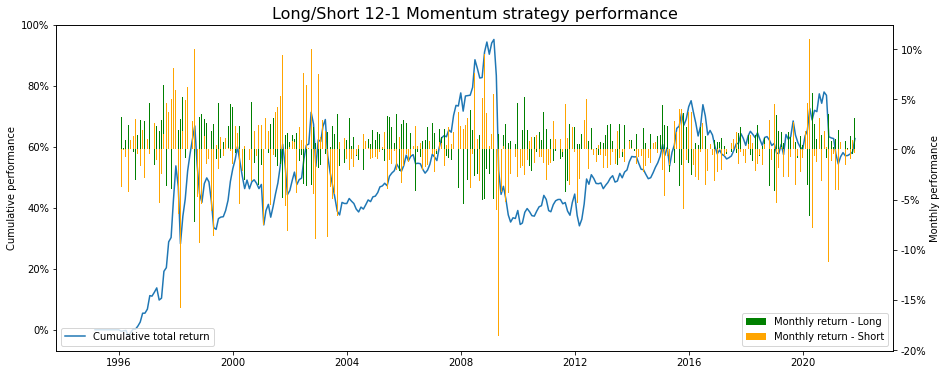

In [1150]:
# Plot LS 12-1 momentum strategy cumulative performance on primary axis
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(backtest_df.index, backtest_df['Cumulative total return']) 
ax1.grid(False)
ax1.set_ylabel('Cumulative performance')
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax1.legend(['Cumulative total return'], loc='lower left')

# Plot monthly long and short returns on secondary axis
ax2 = ax1.twinx()
ax2.bar(backtest_df.index, backtest_df['Monthly return - Long'], width=12, alpha=1, color='green')
ax2.bar(backtest_df.index, backtest_df['Monthly return - Short'], width=12, alpha=1, color='orange')
ax2.grid(False)
ax2.set_ylabel('Monthly performance')
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax2.legend(['Monthly return - Long','Monthly return - Short'], loc='lower right')

plt.title('Long/Short 12-1 Momentum strategy performance', fontsize=16)
plt.show()

If it appears that a 12-1 momentum strategy is profitable in most cases, it particularly failed during the Global Financial Crisis: in 2009, momentum strategy performance of the past 12 years was divided by two within a few months' time!

### Analysis
#### Profitability

We start by looking how successful are the long, short and long/short strategies respectively, but counting the instances where each strategy generated a positive income. **Long and long/short strategies perform better than random, as they manage to generate profit more than 50% of the time, unlike the short strategy**.

In [1123]:
# Estimate profitability of Long, Short and Total strategies
def positivity_score(returns):
    positives, negatives = 0, 0
    for num in returns:
        if num >= 0:
            positives += 1
        else:
            negatives += 1
    return positives / (positives + negatives)

# Print results
print('Long momentum strategy generates a positive return ' + str(round(100*positivity_score(backtest_df['Monthly return - Long']),1)) + '% of the time')
print('Short momentum strategy generates a positive return ' + str(round(100*positivity_score(backtest_df['Monthly return - Short']),1)) + '% of the time')
print('Long/Short momentum strategy generates a positive return ' + str(round(100*positivity_score(backtest_df['Monthly total return']),1)) + '% of the time')

Long momentum strategy generates a positive return 66.8% of the time
Short momentum strategy generates a positive return 45.3% of the time
Long/Short momentum strategy generates a positive return 59.0% of the time


#### Annualized performance

As we deal with monthly return, we can write the annualized return of the strategy $r_A$ as $$r_A = (1+ r_{C,D})^\frac{12}{D} \;-1$$ with $r_{C,D}$ the cumulative return over $D$ periods, $D$ being the number of months the strategy was hold for.

In [1128]:
# Total strategy holding periods (in months)
holding_months = np.count_nonzero(backtest_df['AFI stocks'])-1 # -1 as no data beyond 31 October 2021
# Calculate annualized return of Long, Short, and overall Long/Short strategy
table = [['Long', round(100*((1 + backtest_df['Cumulative Long return'][-1])**(12/holding_months)-1),2)], \
         ['Short', round(100*((1 + backtest_df['Cumulative Short return'][-1])**(12/holding_months)-1),2)], \
         ['Total Long/Short', round(100*((1 + backtest_df['Cumulative total return'][-1])**(12/holding_months)-1),2)] ]
header = ['Strategy','Annualized return (in %)']
print(tabulate(table,headers=header))

Strategy            Annualized return (in %)
----------------  --------------------------
Long                                    6.18
Short                                  -4.55
Total Long/Short                        1.9


Unlike the performance of the long strategy and the long/short strategy, the short momentum strategy is not profitable. It appears that the 12-1 momentum performs better on rising trends than falling ones: **On the 13th month, stocks with a strong positive 12-1 momentum tend to rise, while stocks with a strong negative 12-1 momentum appear to rebound**.

#### Annualized Volatility

The square root of time rule is a heuristic for rescaling the volatility estimate of a particular time series to a new data frequency. The rule assumes that our data are the sum of i.i.d. random variables. This applies to many random processes used in finance. Even when these basic assumptions do not hold, scaling volatility by the square root of time can still be a useful heuristic for estimating volatility to a first approximation.

A rough yet simple approach to derive the annualized volatility of a strategy is to estimate the standard deviation of the monthly returns over the backtesting period, and annualize the result by multiplying it by the square root of 12. As such, we can express the annualized volatility as $$\sigma_A = \sqrt{12} \times \sum_{t=1}^D\frac{(r_{m,t}-\bar{r})^2}{D}$$ scaling volatility with $\sqrt{12}$ due to monthly returns.

In [1129]:
# Calculate annualized volatility of Long, Short, and overall Long/Short strategy
table = [['Long', round(100*(np.std(backtest_df['Monthly return - Long']) * np.sqrt(12)),2)], \
         ['Short', round(100*(np.std(backtest_df['Monthly return - Short']) * np.sqrt(12)),2)], \
         ['Total Long/Short', round(100*(np.std(backtest_df['Monthly total return']) * np.sqrt(12)),2)] ]
header = ['Strategy','Annualized volatility (in %)']
print(tabulate(table,headers=header))

Strategy            Annualized volatility (in %)
----------------  ------------------------------
Long                                        7.21
Short                                      11.87
Total Long/Short                            9.64


#### Return over risk ratio

**The return over risk ratio is a simple way to measure how much return can be generated by one unit of risk taken. The higher the ratio, the better the investment**. As we could anticipate from the above, the long strategy performs greatly, to the detriment of the long, and, to some extent, also the long/short strategy.

In [1130]:
# Calculate return over risk ratios for long, short and long/short strategies
table = [['Long', round(((1 + backtest_df['Cumulative Long return'][-1])**(12/holding_months)-1)/(np.std(backtest_df['Monthly return - Long']) * np.sqrt(12)),2)], \
         ['Short', round(((1 + backtest_df['Cumulative Short return'][-1])**(12/holding_months)-1)/(np.std(backtest_df['Monthly return - Short']) * np.sqrt(12)),2)], \
         ['Total Long/Short', round(((1 + backtest_df['Cumulative total return'][-1])**(12/holding_months)-1)/(np.std(backtest_df['Monthly total return']) * np.sqrt(12)),2)] ]
header = ['Strategy','Return-over-Risk ratio']
print(tabulate(table,headers=header))

Strategy            Return-over-Risk ratio
----------------  ------------------------
Long                                  0.86
Short                                -0.38
Total Long/Short                      0.2


#### Selected VS AFI stocks

As explained in the introduction, we can only invest in selected stocks (e.g. which are part of the 20% top - strong positive momentum, or 20% bottom - strong negative momentum. However, an additional criteria for investment is to ensure that these selected stocks remain part of the MSCI World Index in the next period - what we have called 'Available For Investment' stocks above. In this section, **we look at how much and how often we select stocks at the end of a month, which appear not to be part of the Index in the following month**.

count     321
unique     36
top         1
freq       69
dtype: int64


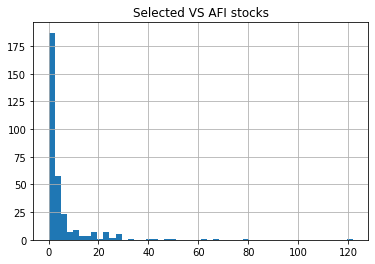

In [1148]:
# Calculate difference between 'Selected stocks' and 'AFI stocks' quantities
AFI_diff = backtest_df['Selected stocks'] - backtest_df['AFI stocks']
print(AFI_diff.describe())
# Plot the difference
plt.plot(figsize = (8,6))
AFI_diff.hist(bins=50);
plt.title('Selected VS AFI stocks');

Most of the time, the amount AFI stocks is very close to the amount of selected stocks, which means that the turnover in the MSCI World Index is rather stable on a monthly basis. Interestingly, we also see **some instance of the right side of the plot where AFI stocks largely differs from Selected stocks, in the situation of stressed markets**. As an example, the largest difference occurred in May 2008:
- 349 stocks selected as part of the long and short buckets respectively
- Only 319 stocks among the long bucket list, and 257 stocks among the short bucket list appear to be part of the MSCI World Index in June 2008
- From 698 selected stocks in May 2008, only 576 were still part of the MSCI World Index in June 2008, e.g. a difference of 122 stocks

### Conclusion

Momentum appears to be a powerful thing, but with unequal conclusions:
- the long part of the 12-1 momentum strategy provides solid returns: annual return of 6.18% for an annual volatility of 7.21%
- the short part of the 12-1 momentum strategy provides solid returns: annual return of -4.55% for an annual volatility of 11.87%
- the long/short 12-1 momentum strategy provides an annual return of 1.9% for a volatility of 9.64%.


**If 12-1 momentum assumption appears to be true for rising stocks, the backtest says differently for falling stocks, as they appear to rebound and not continue on their downward trend**.

**Long/Short 12-1 momentum strategy appears to outperform the market most of the time. Nevertheless, it performs very poorly in some instances as in the 2008 Global Financial Crisis, which considerably affects the overall strategy performance over the period.**

# Strategy enhancements

Now that **we have some common understanding of how the 12-1 long/short momentum works, our objective is to find approaches that deliver a superior return over risk ratio than the 12-1 momentum**. Note that in this section, we call as:
- top stocks: 20% stocks within the MSCI World Index with the strongest positive momentum
- bottom stocks: 20% stocks within the MSCI World Index with the strongest negative momentum

We start by **creating a momentum class in order to easily optimize, test and compare momentum strategies between them**. Then, we try the following strategies:

1. Half-momentum, half-contrarian strategy: long top stocks **AND** bottom stocks
2. Combination of 12-1 and 6-1 momentum top and bottom stocks
3. Momentums from risk-adjusted returns
4. Pull-back contrarian strategy
5. Hierarchical Risk Parity portfolio optimization

## Build Class for the momentum strategy

In [1151]:
class mom_strategy():
    
    """
    Class to build momentum-1 strategies with different time periods
    Curent return not taken into account (e.g. why we say momentum - 1) in attempt to remove short-term reversals
    
    Attributes: 
        dataframe        : dataframe [Monthly returns for stocks in MSCI World Index]
        horizon          : int [time period]
        percentage       : float [% of the total number of stocks picked as part of the Long and Short strategy]
        top_strategy     : text [indicates if strategy on top selected stocks is 'Long' or 'Short']
        bottom_strategy  : text [indicates if strategy on bottom selected stocks is 'Long' or 'Short']  
    """    
    
    def __init__(self, dataframe, horizon, percentage, top_strategy, bottom_strategy):
        
        # Spot dataframe
        self.dataframe = dataframe
        # Momentum time horizon
        self.horizon = horizon
        # Percentage of stocks to select among the investment universe
        self.percentage = percentage
        # Indication to go Long or Short the top selected stocks
        self.top_strategy = top_strategy
        # Indication to go Long or Short the bottom selected stocks
        self.bottom_strategy = bottom_strategy
        
        
    # Momentum-1 function
    def momentum_1(self):
        """
        function to calculate the momentum-1
        """
        return ((1+self.dataframe).rolling(window=self.horizon).apply(np.prod, raw=True)/(1+self.dataframe).rolling(window=1).apply(np.prod, raw=True)) - 1

    # Get TOP (strongest upward momentum) and BOTTOM (strongest downward momentum) stocks 
    def get_stocks(self, bucket, output):
        """
        function to get momentum TOP or BOTTOM stocks
            bucket: 'top' to select stocks with highest momentum, 'bottom' to select stocks with lowest momentum
            output: 'identifiers' to get stock IDs, 'momentums' to get momentum values
        """
        # Calculate momentum dataframe
        mom = self.momentum_1().T
        # Estimate total number of stocks at each date
        universe = mom.count(axis=0)
        # Number of stocks part of the TOP and BOTTOM strategies
        nb_LS = round(universe * self.percentage,0)
        # Identify TOP and BOTTOM stocks
        stocks = []
        values = []
        for item, col in enumerate(mom.columns):
            if bucket == 'top':
                momentums = mom[col].nlargest(int(nb_LS[item]))
            elif bucket == 'bottom':
                momentums = mom[col].nsmallest(int(nb_LS[item]))
            mom_stocks = list(momentums.index.values)
            stocks.append(mom_stocks)
            mom_values = list(momentums.values)
            values.append(mom_values)
        
        # Store TOP stocks and their momentum intensity in a dataframe
        stocks_df = pd.DataFrame(stocks, index = mom.columns).T
        stocks_df = stocks_df.replace(np.nan,0)
        stocks_df = stocks_df.astype(int)
        values_df= pd.DataFrame(values, index = mom.columns)
        if output == 'identifiers':
            return stocks_df
        if output == 'momentums':
            return values_df

    # Backtest of the momentum strategy
    def backtest(self, top_stocks, bottom_stocks):
        """
        function to backtest the momentum strategy
            top_stocks: identifiers for TOP stocks: get_stocks('top','identifiers')
            bottom_stocks: identifiers for BOTTOM stocks: get_stocks('bottom','identifiers')
        """        
        # Build dataframe for backtest
        backtest_dataframe = pd.DataFrame(columns = ['Selected stocks', 'AFI - Top', 'AFI - Bottom', 'AFI stocks', \
                                       'Monthly return - Top', 'Cumulative Top return','Monthly return - Bottom',\
                                       'Cumulative Bottom return', 'Monthly total return','Cumulative total return'], \
                            index=mom.columns)
        
        # Get total number of selected TOP and BOTTOM stocks every month
        for i in range(len(backtest_dataframe)):
            backtest_dataframe['Selected stocks'][i] = np.count_nonzero(top_stocks.iloc[:,i]) + np.count_nonzero(bottom_stocks.iloc[:,i])

        # Get TOP momentum stocks Available For Investment (AFI)
        for i in range(len(top_stocks.columns)-1): # -1 as no data beyond 31 October 2021
            AFI_top = 0 # long stocks Available For Investment
            for j in range(len(top_stocks)):
                if backtest_dataframe['Selected stocks'][i] != 0 and top_stocks.iloc[j,i] != 0:
                    if np.isnan(df[top_stocks.iloc[j,i]][i+1]) == False:
                        AFI_top = AFI_top + 1
            backtest_dataframe['AFI - Top'][i] = AFI_top

        # Get BOTTOM momentum stocks Available For Investment (AFI)
        for i in range(len(bottom_stocks.columns)-1): # -1 as no data beyond 31 October 2021
            AFI_bottom = 0 # long stocks Available For Investment
            for j in range(len(bottom_stocks)):
                if backtest_dataframe['Selected stocks'][i] != 0 and bottom_stocks.iloc[j,i] != 0:
                    if np.isnan(df[bottom_stocks.iloc[j,i]][i+1]) == False:
                        AFI_bottom = AFI_bottom + 1
            backtest_dataframe['AFI - Bottom'][i] = AFI_bottom
        backtest_dataframe['AFI stocks'] = backtest_dataframe['AFI - Top'] + backtest_dataframe['AFI - Bottom']

        # Get performance of TOP momentum strategy
        for i in range(len(top_stocks.columns)-1): # -1 as no data beyond 31 October 2021
            strat_return = 0
            for j in range(len(top_stocks)):
                if backtest_dataframe['Selected stocks'][i] != 0 and top_stocks.iloc[j,i] != 0:
                    if np.isnan(df[top_stocks.iloc[j,i]][i+1]) == False:
                        if self.top_strategy == 'Long':
                            indiv_return = 1/backtest_dataframe['AFI stocks'][i] * df[top_stocks.iloc[j,i]][i+1]
                        elif self.top_strategy == 'Short':
                            indiv_return = -1/backtest_dataframe['AFI stocks'][i] * df[top_stocks.iloc[j,i]][i+1] # minus, as short position
                        strat_return += indiv_return
            backtest_dataframe['Monthly return - Top'][i+1] = strat_return # +1 as first instance of i correspond to strategy initiation
        backtest_dataframe['Cumulative Top return'] = (1 + backtest_dataframe['Monthly return - Top']).cumprod() - 1

        # Get performance of BOTTOM momentum strategy
        for i in range(len(bottom_stocks.columns)-1): # -1 as no data beyond 31 October 2021
            strat_return = 0
            for j in range(len(bottom_stocks)):
                if backtest_dataframe['Selected stocks'][i] != 0 and bottom_stocks.iloc[j,i] != 0:
                    if np.isnan(df[bottom_stocks.iloc[j,i]][i+1]) == False:
                        if self.bottom_strategy == 'Long':
                            indiv_return = 1/backtest_dataframe['AFI stocks'][i] * df[bottom_stocks.iloc[j,i]][i+1]
                        elif self.bottom_strategy == 'Short':
                            indiv_return = -1/backtest_dataframe['AFI stocks'][i] * df[bottom_stocks.iloc[j,i]][i+1] # minus, as short position
                        strat_return += indiv_return
            backtest_dataframe['Monthly return - Bottom'][i+1] = strat_return # +1 as first instance of i correspond to strategy initiation
        backtest_dataframe['Cumulative Bottom return'] = (1 + backtest_dataframe['Monthly return - Bottom']).cumprod() - 1

        # Get performance of overall strategy (TOP + BOTTOM momentum stocks)
        backtest_dataframe['Monthly total return'] = backtest_dataframe['Monthly return - Top'] + backtest_dataframe['Monthly return - Bottom']
        backtest_dataframe['Cumulative total return'] = (1 + backtest_dataframe['Monthly total return']).cumprod() - 1
        return backtest_dataframe

    def performance(self, top_stocks, bottom_stocks, result):
        """
        function to plot the  performance of the momentum strategy
            top_stocks: identifiers for TOP stocks: get_stocks('top','identifiers')
            bottom_stocks: identifiers for BOTTOM stocks: get_stocks('bottom','identifiers')
            result: 'plot' to get performance chart, 'scores' to get performance and volatility figures
        """ 
        # Call backtest data for momentum strategy
        backtest_df = self.backtest(top_stocks, bottom_stocks)
        
        # Plot performance of momentum strategy
        if result == 'plot':
            # Plot strategy cumulative performance on primary axis
            fig, ax1 = plt.subplots(figsize=(15,6))
            ax1.plot(backtest_df.index, backtest_df['Cumulative total return']) 
            ax1.grid(False)
            ax1.set_ylabel('Cumulative performance')
            ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
            ax1.legend(['Cumulative total return'], loc='lower left')
            # Plot monthly long and short returns on secondary axis
            ax2 = ax1.twinx()
            ax2.bar(backtest_df.index, backtest_df['Monthly return - Top'], width=12, alpha=1, color='green')
            ax2.bar(backtest_df.index, backtest_df['Monthly return - Bottom'], width=12, alpha=1, color='orange')
            ax2.grid(False)
            ax2.set_ylabel('Monthly performance')
            ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
            ax2.legend(['Monthly return - Top','Monthly return - Bottom'], loc='lower right')
            plt.title('Momentum strategy performance', fontsize=16)
            plt.show()
        
        # Get annualized performance and volatility results of momentum strategy
        if result == 'scores':
            # Total strategy holding periods (in months)
            holding_months = np.count_nonzero(backtest_df['Selected stocks'])-1 # -1 as no data beyond 31 October 2021
            # Calculate annualized return of Long, Short, and overall Long/Short strategy
            table = [['Top', round(100*((1 + backtest_df['Cumulative Top return'][-1])**(12/holding_months)-1),2), round(100*(np.std(backtest_df['Monthly return - Top']) * np.sqrt(12)),2), \
                     round(((1 + backtest_df['Cumulative Top return'][-1])**(12/holding_months)-1)/(np.std(backtest_df['Monthly return - Top']) * np.sqrt(12)),2)], \
                     ['Bottom', round(100*((1 + backtest_df['Cumulative Bottom return'][-1])**(12/holding_months)-1),2), round(100*(np.std(backtest_df['Monthly return - Bottom']) * np.sqrt(12)),2), \
                     round(((1 + backtest_df['Cumulative Bottom return'][-1])**(12/holding_months)-1)/(np.std(backtest_df['Monthly return - Bottom']) * np.sqrt(12)),2)], \
                     ['Total (Top+Bottom)', round(100*((1 + backtest_df['Cumulative total return'][-1])**(12/holding_months)-1),2), round(100*(np.std(backtest_df['Monthly total return']) * np.sqrt(12)),2), \
                     round(((1 + backtest_df['Cumulative total return'][-1])**(12/holding_months)-1)/(np.std(backtest_df['Monthly total return']) * np.sqrt(12)),2)]]
            header = ['Strategy','Annualized return (in %)','Annualized volatility (in %)', 'Return over risk ratio']
            print(tabulate(table,headers=header))

For safety, we check that the class for the momentum strategy returns the same conclusions than in section 2 above.

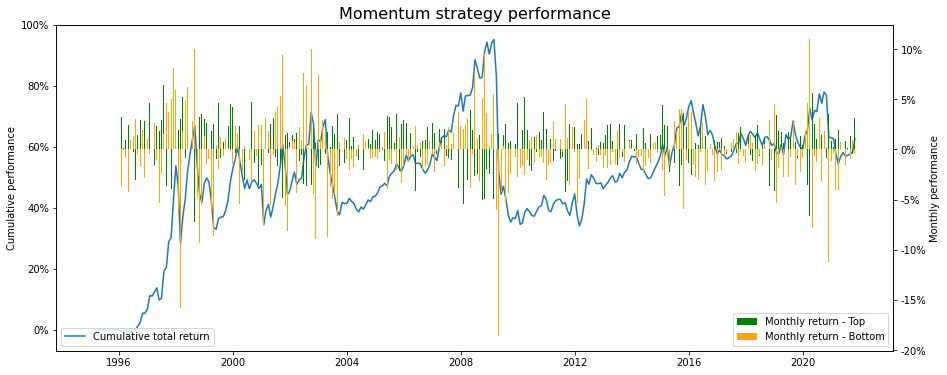

In [1152]:
# Plot performance of long/short 12-1 momentum strategy
top_assets = mom_strategy(df,12,0.2,'Long','Short').get_stocks('top','identifiers')
bottom_assets = mom_strategy(df,12,0.2,'Long','Short').get_stocks('bottom','identifiers')
mom_strategy(df,12,0.2,'Long','Short').performance(top_assets, bottom_assets, 'plot')

In [1153]:
# Get annualized performance and volatility of long/short 12-1 momentum strategy
mom_strategy(df,12,0.2,'Long','Short').performance(top_assets, bottom_assets, 'scores')

Strategy              Annualized return (in %)    Annualized volatility (in %)    Return over risk ratio
------------------  --------------------------  ------------------------------  ------------------------
Top                                       6.18                            7.21                      0.86
Bottom                                   -4.55                           11.87                     -0.38
Total (Top+Bottom)                        1.9                             9.64                      0.2


Performance chart and model results are exactly equal to section 2! Our momentum class works well.

## Half-momentum, half-contrarian strategy

As concluded in section 2, momentum can be a powerful thing:
- Stocks with a strong positive 12-1 momentum appear to continue performing on their 13th month. 
- On the opposite, stocks with a strong negative 12-1 momentum appear not to continue their route towards lower lows, as shorting them on the 13th month results in a negative return over the backtesting period. Said differently, stocks with a strong negative trend seem to rebound on the 13th month.

**STRATEGY**: half-momentum (long the top momentum stocks), half-contrarian (also long the bottom momentum stocks)

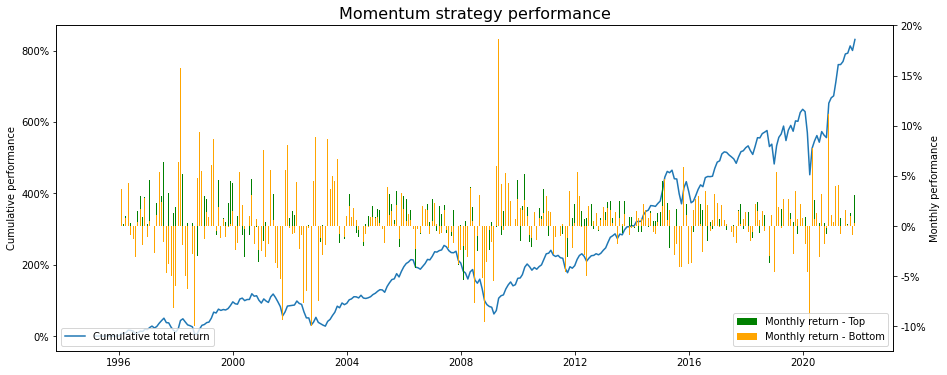

In [1155]:
# Plot performance of long/long 12-1 momentum strategy
top_assets = mom_strategy(df,12,0.2,'Long','Long').get_stocks('top','identifiers')
bottom_assets = mom_strategy(df,12,0.2,'Long','Long').get_stocks('bottom','identifiers')
mom_strategy(df,12,0.2,'Long','Long').performance(top_assets, bottom_assets, 'plot')

In [1156]:
# Get annualized performance and volatility of long/long 12-1 momentum strategy
mom_strategy(df,12,0.2,'Long','Long').performance(top_assets, bottom_assets, 'scores')

Strategy              Annualized return (in %)    Annualized volatility (in %)    Return over risk ratio
------------------  --------------------------  ------------------------------  ------------------------
Top                                       6.18                            7.21                      0.86
Bottom                                    3.23                           11.87                      0.27
Total (Top+Bottom)                        9.02                           17.11                      0.53


As we could expect from section 2 results above, our half-momentum, half-contrarian strategy returned a much better return over risk ratio. 

**CONCLUSION**:
- The return over risk ratio for our long/long 12-1 momentum strategy jumped from 0.2 to 0.5, e.g. one unit of risk returns 2.5 times more profit than our long/short 12-1 momentum strategy from section 2. 
- This increase in performance comes with a downside: our long/long 12-1 momentum strategy is considerably more volatile than the long/short one. Despite a higher return over risk ratio, it cannot be proposed as an investment to risk-adverse investors, unlike the initial strategy.

## Combination of 12-1 and 6-1 momentum

As observed in section 2, momentum is a powerful things in some cases. Nevertheless, we observed than shorting the bottom 12-1 momentum stocks was not a profitable strategy, as these stocks reverted on the 13th month.

**STRATEGY**: select as strategy top (resp. bottom) stocks only the stocks which are identified as top (resp. bottom) stocks in both 12-1 and 6-1 momentum strategies, in an attempt to capture stocks with a solid trend which have not reverted back, for long/short and long/long strategies.

In [1157]:
# Get 12-1 TOP and BOTTOM momentum stocks
top_stocks_12 = mom_strategy(df,12,0.2,'Long','Short').get_stocks('top', 'identifiers')
bottom_stocks_12 = mom_strategy(df,12,0.2,'Long','Short').get_stocks('bottom', 'identifiers')
# Get 6-1 TOP and BOTTOM momentum stocks
top_stocks_6 = mom_strategy(df,6,0.2,'Long','Short').get_stocks('top', 'identifiers')
bottom_stocks_6 = mom_strategy(df,6,0.2,'Long','Short').get_stocks('bottom', 'identifiers')

In [1158]:
# Get common 12-1 and 6-1 TOP momentum stocks
common_top_list = []
for col in top_stocks_12.columns:
    common_top = set(top_stocks_12[col]).intersection(top_stocks_6[col])
    common_top_list.append(common_top)
common_top_stocks = pd.DataFrame(common_top_list, index = top_stocks_12.columns).T
common_top_stocks = common_top_stocks.replace(np.nan,0)
common_top_stocks = common_top_stocks.astype(int)

# Get common 12-1 and 6-1 BOTTOM momentum stocks
common_bottom_list = []
for col in bottom_stocks_12.columns:
    common_bottom = set(bottom_stocks_12[col]).intersection(bottom_stocks_6[col])
    common_bottom_list.append(common_bottom)
common_bottom_stocks = pd.DataFrame(common_bottom_list, index = bottom_stocks_12.columns).T
common_bottom_stocks = common_bottom_stocks.replace(np.nan,0)
common_bottom_stocks = common_bottom_stocks.astype(int)

### Long/Short strategy

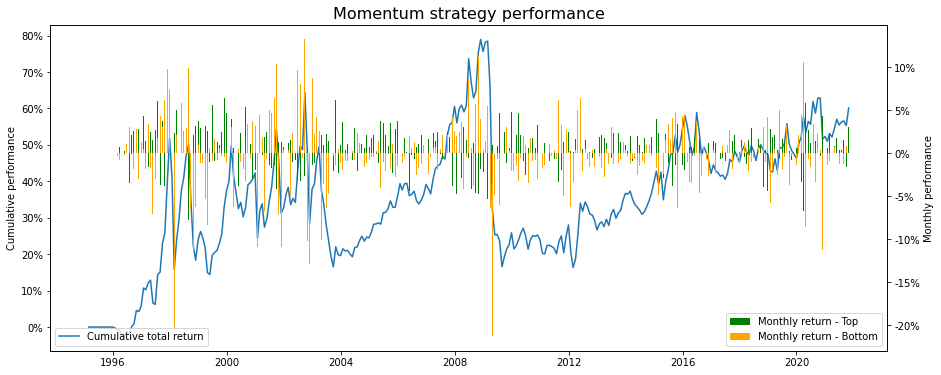

In [1160]:
# Plot 12-1 / 6-1 long/short model performance
mom_strategy(df,12,0.2,'Long','Short').performance(common_top_stocks, common_bottom_stocks, 'plot')

In [1161]:
# Get 12-1 / 6-1 long/short model annualized performance and volatility
mom_strategy(df,12,0.2,'Long','Short').performance(common_top_stocks, common_bottom_stocks, 'scores')

Strategy              Annualized return (in %)    Annualized volatility (in %)    Return over risk ratio
------------------  --------------------------  ------------------------------  ------------------------
Top                                       6.84                            7.39                      0.92
Bottom                                   -5.17                           13.86                     -0.37
Total (Top+Bottom)                        1.84                           12.3                       0.15


### Long/Long strategy

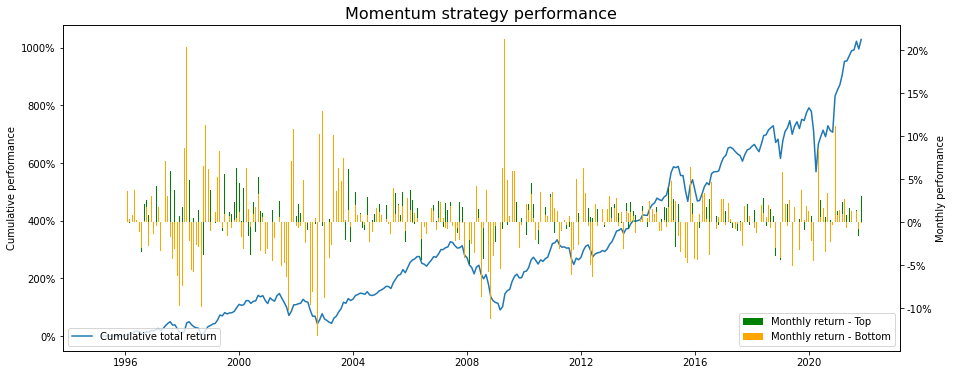

In [1162]:
# Plot 12-1 / 6-1 long/long model performance
mom_strategy(df,12,0.2,'Long','Long').performance(common_top_stocks, common_bottom_stocks, 'plot')

In [1163]:
# Get 12-1 / 6-1 long/long model annualized performance and volatility
mom_strategy(df,12,0.2,'Long','Long').performance(common_top_stocks, common_bottom_stocks, 'scores')

Strategy              Annualized return (in %)    Annualized volatility (in %)    Return over risk ratio
------------------  --------------------------  ------------------------------  ------------------------
Top                                       6.84                            7.39                      0.92
Bottom                                    3.35                           13.86                      0.24
Total (Top+Bottom)                        9.84                           18.5                       0.53


**CONCLUSION**:
- Long top strategy performs better than initial strategy (ratio increased from 0.86 to 0.92)
- A contrarian (long) approach keep working better than traditional (short) approach on the bottom strategy
- The initial long/short strategy performs better than this one
- The long/long 12-1 and long/long 12-1/6-1 momentum strategies share the same ratio of 0.53, the former running on a lower level of return (9.02% against 9.84%) and volatility (17.1% against 18.5%)

## Risk-adjusted returns

As what we aspire to achieve is to improve the return over risk ratio of our strategy, it appears natural to implement the traditional long/short 12-1 momentum strategy, with top and bottom momentum derived from risk-adjusted returns instead of simple returns. Risk-adjusted return is a critical element to successful long-term investing, as, as mentioned above, the return potential of any investment should be viewed in the context of the risks it takes to achieve that return.

**STRATEGY**: Long/long 12-1 momentum strategy with top and bottom stocks derived from risk-adjusted returns.

In order to remain consistent with 12-1 momentum calculations, we use the standard deviation of the past 12 months to estimate the volatility, and we define risk-adjusted returns at time t $ra_t$ as $$ra_t=\frac{r_t}{\frac{\sum_{i=1}^{12}(r_{t-i+1}-\bar{r})^2}{12}}$$

In [1172]:
# Function to obtain risk-adjusted returns
def risk_return(returns, period):
    volatility = returns.rolling(window=period).std()
    risk_return = returns / volatility * np.sqrt(period)
    return risk_return

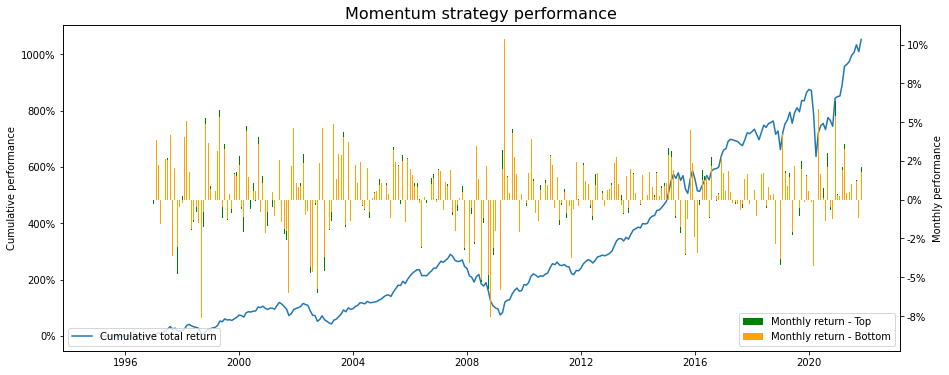

In [1175]:
# Get risk-adjusted monthly returns
risk_adj_df = risk_return(df,12)
# Plot performance of long/long 12-1 momentum strategy
top_assets = mom_strategy(risk_adj_df,12,0.2,'Long','Long').get_stocks('top','identifiers')
bottom_assets = mom_strategy(risk_adj_df,12,0.2,'Long','Long').get_stocks('bottom','identifiers')
mom_strategy(risk_adj_df,12,0.2,'Long','Long').performance(top_assets, bottom_assets, 'plot')

In [1176]:
# Get performance and volatility results
mom_strategy(risk_adj_df,12,0.2,'Long','Long').performance(top_assets, bottom_assets, 'scores')

Strategy              Annualized return (in %)    Annualized volatility (in %)    Return over risk ratio
------------------  --------------------------  ------------------------------  ------------------------
Top                                       4.99                            7.57                      0.66
Bottom                                    5.73                            7.62                      0.75
Total (Top+Bottom)                       10.31                           15.13                      0.68


**CONCLUSION**:
- The long top strategy performs less than all other strategies, with a ratio of 0.66 (0.86 for initial strategy)
- On the other side, the long bottom strategy performs significantly well, with a ratio of 0.75 (-0.38 for initial strategy, and 0.27 for long/long 12-1 momentum strategy in 3.2)
- **Long/long 12-1 momentum strategy with risk-adjusted returns generated the highest return over risk ratio so far!**

## Trend validation

We now look to be more specific to the stocks we decide to buy or short among the top and bottom buckets. 

### Relative Strength Index (RSI)
The Relative Strength Index is a known contrarian indicator, which measures the speed and change of price movements. It is also bounded between 0 and 100 which makes it easier to interpret.

$$RSI = 100 - \frac{100}{1+RS}$$ with $RS = \frac{ewma \,(positive \,returns)}{ewma\, (negative\, returns)}$

Therefore, we can use the RSI to initiate contrarian trades for overbought (RSI > 70) or oversold (RSI < 30) stocks, and go on with our classic 12-1 momentum strategy for RSI values greater than 30 and lower than 70.

In fact:
- Overbought market (RSI > 70):too much bullish momentum, possible downward correction to come
- Oversold market (RSI < 30): too much bearish momentum, possible upward correction to come

**STRATEGY**:
- For top stocks with strong positive momentum: Buy if RSI < 70, otherwise sell
- For bottom stocks with strong negative momentum: Sell if RSI > 30, otherwise buy

In [1177]:
def get_RSI(dataframe, lookback):  
    up_returns = dataframe[dataframe > 0]
    down_returns = dataframe[dataframe < 0]
    up_returns_avg = up_returns.ewm(com=lookback-1, adjust = True, min_periods=round(lookback/2,0)-1).mean()
    down_returns_avg = down_returns.ewm(com=lookback-1, adjust = True, min_periods=round(lookback/2,0)- 1).mean()
    rs = abs(up_returns_avg/down_returns_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [1190]:
# Get top and bottom stocks
top_assets = mom_strategy(df,12,0.2,'Long','Short').get_stocks('top','identifiers')
bottom_assets = mom_strategy(df,12,0.2,'Long','Short').get_stocks('bottom','identifiers')

# Calculate RSI
RSI_df = get_RSI(df,12)

# Build dataframe for backtest
backtest_RSI = pd.DataFrame(columns = ['Selected stocks', 'AFI - Top', 'AFI - Bottom', 'AFI stocks', \
                                       'Monthly return - Top', 'Cumulative Top return','Monthly return - Bottom',\
                                       'Cumulative Bottom return', 'Monthly total return','Cumulative total return'], \
                            index=mom.columns)

# Get monthly total number of selected stocks
for i in range(len(backtest_RSI)):
    backtest_RSI['Selected stocks'][i] = np.count_nonzero(top_assets.iloc[:,i]) + np.count_nonzero(bottom_assets.iloc[:,i])

# Get AFI - Long
for i in range(len(top_assets.columns)-1): # -1 as no data beyond 31 October 2021
    AFI_long = 0 # long stocks Available For Investment
    for j in range(len(top_assets)):
        if backtest_RSI['Selected stocks'][i] != 0 and top_assets.iloc[j,i] != 0:
            if np.isnan(df[top_assets.iloc[j,i]][i+1]) == False:
                AFI_long = AFI_long + 1
    backtest_RSI['AFI - Top'][i] = AFI_long

# Get AFI - Short
for i in range(len(bottom_assets.columns)-1): # -1 as no data beyond 31 October 2021
    AFI_short = 0 # long stocks Available For Investment
    for j in range(len(bottom_assets)):
        if backtest_RSI['Selected stocks'][i] != 0 and bottom_assets.iloc[j,i] != 0:
            if np.isnan(df[bottom_assets.iloc[j,i]][i+1]) == False:
                AFI_short = AFI_short + 1
    backtest_RSI['AFI - Bottom'][i] = AFI_short
    
# Get total AFI stocks
backtest_RSI['AFI stocks'] = backtest_RSI['AFI - Top'] + backtest_RSI['AFI - Bottom']

In [1192]:
# Get performance of TOP strategy
for i in range(len(top_assets.columns)-1): # -1 as no data beyond 31 October 2021
    strat_return = 0
    for j in range(len(top_assets)):
        if top_assets.iloc[j,i] != 0 and np.isnan(df[top_assets.iloc[j,i]][i+1]) == False:
            # RSI contrarian criteria
            if RSI_df[top_assets.iloc[j,i]][i] < 70:
                indiv_return = 1/backtest_RSI['AFI stocks'][i] * df[top_assets.iloc[j,i]][i+1] # Long position if RSI < 70 (trend confirmation)
            else:
                indiv_return = -1/backtest_RSI['AFI stocks'][i] * df[top_assets.iloc[j,i]][i+1] # Short position if RSI >= 70 (contrarian)
            strat_return += indiv_return
    backtest_RSI['Monthly return - Top'][i+1] = strat_return # i+1 as first instance of i correspond to strategy initiation
backtest_RSI['Cumulative Top return'] = (1 + backtest_RSI['Monthly return - Top']).cumprod() - 1

# Get performance of BOTTOM strategy
for i in range(len(bottom_assets.columns)-1): # -1 as no data beyond 31 October 2021
    strat_return = 0
    for j in range(len(bottom_assets)):
        if bottom_assets.iloc[j,i] != 0 and np.isnan(df[bottom_assets.iloc[j,i]][i+1]) == False:
            # RSI contrarian criteria
            if RSI_df[bottom_assets.iloc[j,i]][i] > 30:
                indiv_return = -1/backtest_RSI['AFI stocks'][i] * df[bottom_assets.iloc[j,i]][i+1] # Short position if RSI > 30 (trend confirmation)
            else:    
                indiv_return = 1/backtest_RSI['AFI stocks'][i] * df[bottom_assets.iloc[j,i]][i+1] # Long position if RSI <= 30 (trend confirmation)
            strat_return += indiv_return
    backtest_RSI['Monthly return - Bottom'][i+1] = strat_return # +1 as first instance of i correspond to strategy initiation
backtest_RSI['Cumulative Bottom return'] = (1 + backtest_RSI['Monthly return - Bottom']).cumprod() - 1

# Get performance of overall strategy (Long + Short)
backtest_RSI['Monthly total return'] = backtest_RSI['Monthly return - Top'] + backtest_RSI['Monthly return - Bottom']
backtest_RSI['Cumulative total return'] = (1 + backtest_RSI['Monthly total return']).cumprod() - 1
backtest_RSI

,Selected stocks,AFI - Top,AFI - Bottom,AFI stocks,Monthly return - Top,Cumulative Top return,Monthly return - Bottom,Cumulative Bottom return,Monthly total return,Cumulative total return
1995-01-31,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-28,0,0,0,0,0,0.0,0,0.0,0,0.0
1995-03-31,0,0,0,0,0,0.0,0,0.0,0,0.0
1995-04-30,0,0,0,0,0,0.0,0,0.0,0,0.0
1995-05-31,0,0,0,0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-30,592,295,296,591,0.003977,2.061638,-0.013897,-0.6133,-0.00992,0.311799
2021-07-31,590,294,295,589,-0.000886,2.058925,-0.000893,-0.613646,-0.001779,0.309465
2021-08-31,592,296,294,590,0.011016,2.092624,-0.009743,-0.61741,0.001273,0.311132
2021-09-30,592,294,296,590,-0.002141,2.086002,0.00908,-0.613936,0.006938,0.320229


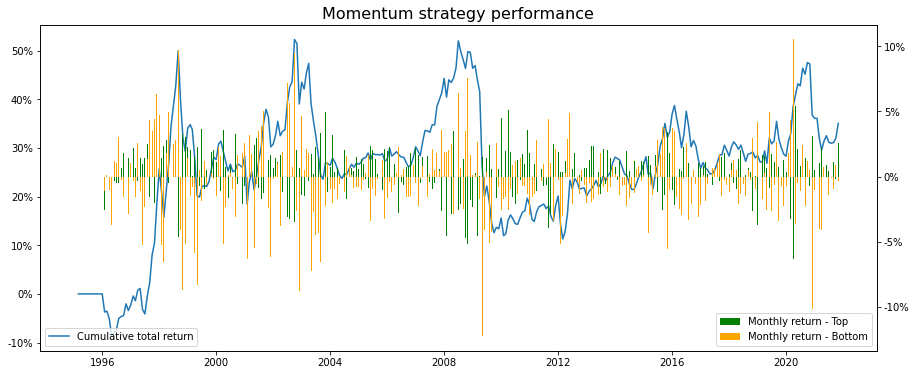

In [1193]:
# Plot strategy cumulative performance on primary axis
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(backtest_RSI.index, backtest_RSI['Cumulative total return']) 
ax1.grid(False)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax1.legend(['Cumulative total return'], loc='lower left')

# Plot monthly long and short returns on secondary axis
ax2 = ax1.twinx()
ax2.bar(backtest_RSI.index, backtest_RSI['Monthly return - Top'], width=12, alpha=1, color='green')
ax2.bar(backtest_RSI.index, backtest_RSI['Monthly return - Bottom'], width=12, alpha=1, color='orange')
ax2.grid(False)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax2.legend(['Monthly return - Top','Monthly return - Bottom'], loc='lower right')

plt.title('Momentum strategy performance', fontsize=16)
plt.show()

In [1194]:
# Get annualized performance and volatility results of
holding_months = np.count_nonzero(backtest_RSI['Selected stocks'])-1 # -1 as no data beyond 31 October 2021
# Calculate annualized return of Long, Short, and overall Long/Short strategy
table = [['Top', round(100*((1 + backtest_RSI['Cumulative Top return'][-1])**(12/holding_months)-1),2), round(100*(np.std(backtest_RSI['Monthly return - Top']) * np.sqrt(12)),2), \
            round(((1 + backtest_RSI['Cumulative Top return'][-1])**(12/holding_months)-1)/(np.std(backtest_RSI['Monthly return - Top']) * np.sqrt(12)),2)], \
            ['Bottom', round(100*((1 + backtest_RSI['Cumulative Bottom return'][-1])**(12/holding_months)-1),2), round(100*(np.std(backtest_RSI['Monthly return - Bottom']) * np.sqrt(12)),2), \
            round(((1 + backtest_RSI['Cumulative Bottom return'][-1])**(12/holding_months)-1)/(np.std(backtest_RSI['Monthly return - Bottom']) * np.sqrt(12)),2)], \
            ['Total (Top+Bottom)', round(100*((1 + backtest_RSI['Cumulative total return'][-1])**(12/holding_months)-1),2), round(100*(np.std(backtest_RSI['Monthly total return']) * np.sqrt(12)),2), \
            round(((1 + backtest_RSI['Cumulative total return'][-1])**(12/holding_months)-1)/(np.std(backtest_RSI['Monthly total return']) * np.sqrt(12)),2)]]
header = ['Strategy','Annualized return (in %)','Annualized volatility (in %)', 'Return over risk ratio']
print(tabulate(table,headers=header))

Strategy              Annualized return (in %)    Annualized volatility (in %)    Return over risk ratio
------------------  --------------------------  ------------------------------  ------------------------
Top                                       4.56                            5.91                      0.77
Bottom                                   -3.63                           10.05                     -0.36
Total (Top+Bottom)                        1.17                            7.86                      0.15


### Hurst exponent

The Hurst exponent $H$ is a statistical measure that is used to quantify the long-term memory or persistence of a time series. It is often used to **identify whether a time series exhibits mean-reverting or trending behavior**, which could be helpful in our case, as **we only want to keep in our momentum strategy stocks which have a clear trend only**.

The Hurst exponent H represents the relative tendency of a time series either to regress strongly to the mean (mean-reverting pattern) or to cluster in a certain direction (trending pattern). Its values range between 0 and 1. Based on the value of H, we can classify any time series into one of the three categories:

- H < 0.5:  mean-reverting (anti-persistent) series. The closer the value is to 0, the stronger the mean-reversion process is. In practice, it means that a high value is followed by a low value and vice-versa
- H = 0.5: geometric random walk
- H > 0.5: trending (persistent) series. The closer the value is to 1, the stronger the trend. In practice, it means that a high value is followed by a higher one (and that a low value is followed by a lower one)

We calculate the Hurst exponent to top and bottom stocks, in order to identify in each bucket stocks with a clear trend pattern - according to Hurst criteria.

In [1200]:
def hurst_trend_stocks(dataframe, lookback, output):
    """
    Calculate the Hurst exponent for a dataframe of returns
    """
    trend_stocks = []
    count = 0
    # Identify trending stocks according to Hurst exponent criteria
    for i in range(len(dataframe.columns)):
        h_stocks = []
        for j in range(len(dataframe)):
            if dataframe.iloc[j,i] != 0:
                h_range = df[dataframe.iloc[j,i]][i-(lookback-1):i].values
                h_score = hurst_exponent(h_range)
                if h_score > 0.5: # e.g. stock is trending, so we keep it
                    h_stocks.append(top_assets.iloc[j,i])
                    count = count+1
        trend_stocks.append(h_stocks)
        trend_stocks_df = pd.DataFrame(trend_stocks, index = top_assets.columns).T
    if output == 'quantity':
        print(str(count) + ' stock(s) identified with a clear trend behavior')
    if output == 'table':
        return trend_stocks

In [1201]:
# Get TOP and BOTTOM assets
top_assets = mom_strategy(df,12,0.2,'Long','Short').get_stocks('top','identifiers')
bottom_assets = mom_strategy(df,12,0.2,'Long','Short').get_stocks('bottom','identifiers')

In [1202]:
# Get Hurst buy stocks among TOP 12-1 momentum stocks
hurst_trend_stocks(top_assets,12,'quantity')

0 stock(s) identified with a clear trend behavior


In [1203]:
# Get Hurst short stocks among BOTTOM 12-1 momentum stocks
hurst_trend_stocks(bottom_assets,12,'quantity')

0 stock(s) identified with a clear trend behavior


**CONCLUSION**:

Contrarian ideas led nowhere: RSI and Hurst pull-back strategies, which were attempted to refine the buy/short decision within the top and bottom buckets did not turned out to be more profitable than previous strategies.

## Portfolio optimization

As mentioned at the beginning, traditional momentum strategies are naive, e.g. all assets part of the strategy are attributed with the same weight $w=\frac{1}{n}$, n being the number of assets part of the strategy. The role of this section is to allocate a different weight to each stock in the strategy as a function of its return-risk profile.

### Mean-Variance

Mean-variance optimization (MVO) was initially considered for this section. Nevertheless, **one of the main drawbacks of the MVO framework is that it assumes that asset returns are normally distributed. Therefore, we start by looking whether the main MVO assumption makes sense**. The histogram below plots the monthly returns of the long, short and long/short 12-1 momentum strategy. **At first sight, all three strategies are skewed and far from being normally distributed**.

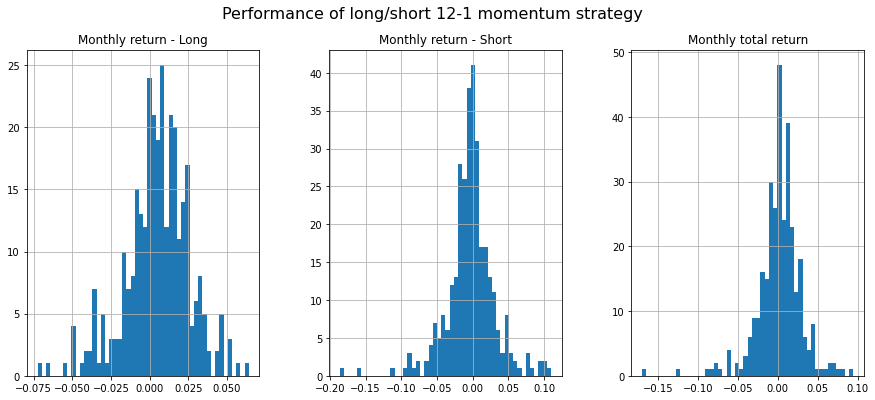

In [1233]:
# Plot histograms of monthly returns
fig, ax = plt.subplots(1,3, figsize = (15,6))
plt.suptitle('Performance of long/short 12-1 momentum strategy', fontsize=16)
monthly_rets = backtest_df[['Monthly return - Long','Monthly return - Short','Monthly total return']] = backtest_df[['Monthly return - Long','Monthly return - Short','Monthly total return']].astype(float)
monthly_rets.hist(bins=50, ax=ax);

Also, the MVO approach suffers from two other drawbacks in this case:
- It requires the covariance matrix to be positive semi-definite, as it makes them and their respective inverse invertible. **Having a covariance matrix positive semi-definite is a key criteria in the MVO process, as positive semi-definite matrices guarantee a unique global minimum in a quadratic optimization problem**. 
- The MVO framework is highly sensitive to estimation errors. Even small changes in estimated returns may result in huge changes in the portfolio content. Hence, **as the number of assets increases in an investment portfolio, the estimated efficient frontier tends to overstate the returns and understate the volatility of the portfolio return**.

Although the first drawback can be easily mitigated (*matrix A is invertible iif its determinant / eigenvalues is non zero, or of the matrix is strictly diagonally dominant*), the last one is significantly more problematic, as we deal with portfolio which can have around 600 securities. Therefore, we choose not to go with the MVO approach, as chances are high to get not relevant results.

### Hierarchical Risk Parity
HRP is a recent portfolio optimization technique developed by Marcos Lopez de Prado (2016), made of four steps:

1. From a universe of assets, form a distance matrix based on the correlation of the assets
2. Using this distance matrix, cluster the assets into a tree via hierarchical clustering to form a dendrogram
3. Within each branch of the tree, form the minimum variance portfolio - normally between just two assets
4. Iterate over each level, optimally combining the mini-portfolios at each node

**The advantages of the HRP approach makes it quite appropriate to our case**, as:
- It does not require the inversion of the covariance matrix as with traditional mean-variance optimization
- It seems to produce diverse portfolios that perform well out of sample
- It is stable for a large number of assets

We run the HRP approach on our half-momentum, half-contrarian (long/long 12-1 momentum) strategy, as the long/long strategies led to the best return-over-risk ratios until now.

In [1210]:
# Get TOP and BOTTOM assets for (naive equal weight) 12-1 long/short momentum strategy
top_assets = mom_strategy(df,12,0.2,'Long','Short').get_stocks('top','identifiers')
bottom_assets = mom_strategy(df,12,0.2,'Long','Short').get_stocks('bottom','identifiers')

In [1212]:
# Function to get stocks IDs
def get_IDs(dataframe, lookback, i):
    r_stocks = []
    for j in range(len(dataframe)):
        # If stock ID not 0 and if the stock is still part of the MSCI World Index in the next month
        if dataframe.iloc[j,i] != 0 and np.isnan(df[dataframe.iloc[j,i]][i+1]) == False:
            r_range = df[dataframe.iloc[j,i]][i-(lookback-1):i+1]
            r_stocks.append(dataframe.iloc[j,i])
    return r_stocks

# Function to get HRP stock IDs
def HRP_stocks(dataframe, lookback):
    IDs = []
    for i in range(len(dataframe.columns)-1):
        stocks = get_IDs(dataframe, lookback, i)
        IDs.append(stocks)
    # Store weights in dataframe
    HRP_stocks_df = pd.DataFrame(IDs).T
    HRP_stocks_df['last'] = np.nan # Add extra column for last date
    HRP_stocks_df.columns = dataframe.columns
    HRP_stocks_df.index = np.arange(1, len(HRP_stocks_df) + 1)
    HRP_stocks_df = HRP_stocks_df.replace(np.nan,0)
    HRP_stocks_df = HRP_stocks_df.astype(int)
    return HRP_stocks_df

In [1213]:
# Get HRP stock IDs
HRP_top_stocks = HRP_stocks(top_assets, 12)
HRP_bottom_stocks = HRP_stocks(bottom_assets, 12)

In [1207]:
# Function to get past 12 months of monthly returns for top and bottom stocks each month
def get_returns_df(dataframe, lookback, i):
    r_stocks = []
    r_rets = []
    for j in range(len(dataframe)):
        # If stock ID not 0 and if the stock is still part of the MSCI World Index in the next month
        if dataframe.iloc[j,i] != 0 and np.isnan(df[dataframe.iloc[j,i]][i+1]) == False:
            r_range = df[dataframe.iloc[j,i]][i-(lookback-1):i+1]
            r_stocks.append(dataframe.iloc[j,i])
            r_rets.append(df[dataframe.iloc[j,i]][i-(lookback-1):i+1].values)
    returns =  pd.DataFrame(r_rets).T
    returns.columns = r_stocks
    returns.index = df.index[i-(lookback-1):i+1]
    return returns

In [1208]:
# Function to estimate the HRP weights to allocate to top and bottom stocks each month
def HRP_weights(dataframe):
    port = rp.HCPortfolio(returns=dataframe)
    # Estimate optimal portfolio:
    model='HRP' # HERC as alternative - equal risk contribution
    codependence = 'pearson' # Correlation matrix used to group assets in clusters
    rm = 'MV' # Risk measure used, this time will be variance
    rf = 0 # Risk free rate
    linkage = 'single' # Linkage method used to build clusters
    max_k = 10 # Max number of clusters used in two difference gap statistic, only for HERC model
    leaf_order = True # Consider optimal order of leafs in dendrogram
    # Get weights
    w = port.optimization(model=model,
                          codependence=codependence,
                          rm=rm,
                          rf=rf,
                          linkage=linkage,
                          max_k=max_k,
                          leaf_order=leaf_order)
    return w[w.columns[0]].values

In [1209]:
# Function to obtain HRP weights in a dataframe each month
def HRP_optim(dataframe, lookback):
    # Get HRP weights
    wts = []
    for i in range(len(dataframe.columns)-1):
        returns = get_returns_df(dataframe, lookback, i)
        if len(returns.columns) > 0:
            weights = HRP_weights(returns)
        else:
            weights = [0]
        wts.append(weights)
    # Store weights in dataframe
    HRP_weights_df = pd.DataFrame(wts).T
    HRP_weights_df['last'] = np.nan # Add extra column for last date
    HRP_weights_df.columns = dataframe.columns
    HRP_weights_df.index = np.arange(1, len(HRP_weights_df) + 1)
    HRP_weights_df = HRP_weights_df.replace(np.nan,0)
    return HRP_weights_df

In [1211]:
# Get HRP weights
HRP_top_weights = HRP_optim(top_assets, 12)
HRP_bottom_weights = HRP_optim(bottom_assets, 12)

In [1215]:
# Illustrate new weights characteristics
HRP_top_weights.describe()

,1995-01-31,1995-02-28,1995-03-31,1995-04-30,1995-05-31,1995-06-30,1995-07-31,1995-08-31,1995-09-30,1995-10-31,...,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31
count,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,363.0,...,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.000000,363.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002755,0.002755,0.002755,0.002755,0.002755,0.002755,0.002755,0.002755,0.002755,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.004643,0.005286,0.004952,0.005035,0.006516,0.008191,0.005545,0.005145,0.004666,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000416,0.000324,0.000336,0.000289,0.000296,0.000272,0.000221,0.000222,0.000389,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.001246,0.001109,0.001380,0.001104,0.001011,0.000899,0.000891,0.000837,0.001314,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.002984,0.002811,0.002942,0.003049,0.002743,0.002243,0.002419,0.002720,0.003276,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.034170,0.047661,0.047828,0.041954,0.094920,0.113430,0.046612,0.036148,0.049693,0.0


As we can see, HRP allocates more weights to some assets in the strategy, as there is for instance a maximum weight of 9.49% as of May 2021. On the other hand, some assets are allocated to zero weight.

In [1219]:
# Build backtest framework
backtest_HRP = pd.DataFrame(columns = ['Selected stocks', 'AFI - Top', 'AFI - Bottom', 'AFI stocks', \
                                       'Monthly return - Top', 'Cumulative Top return','Monthly return - Bottom',\
                                       'Cumulative Bottom return', 'Monthly total return','Cumulative total return'], \
                            index=mom.columns)

# Get total number of selected stocks each month
for i in range(len(backtest_HRP)):
    backtest_HRP['Selected stocks'][i] = np.count_nonzero(HRP_top_stocks.iloc[:,i]) + np.count_nonzero(HRP_bottom_stocks.iloc[:,i])

# Get AFI - Top
for i in range(len(HRP_top_stocks.columns)-1): # -1 as no data beyond 31 October 2021
    AFI_long = 0 # long stocks Available For Investment
    for j in range(len(HRP_top_stocks)):
        if backtest_HRP['Selected stocks'][i] != 0 and HRP_top_stocks.iloc[j,i] != 0:
            if np.isnan(df[HRP_top_stocks.iloc[j,i]][i+1]) == False:
                AFI_long = AFI_long + 1
    backtest_HRP['AFI - Top'][i] = AFI_long

# Get AFI - Bottom
for i in range(len(HRP_bottom_stocks.columns)-1): # -1 as no data beyond 31 October 2021
    AFI_short = 0 # long stocks Available For Investment
    for j in range(len(HRP_bottom_stocks)):
        if backtest_HRP['Selected stocks'][i] != 0 and HRP_bottom_stocks.iloc[j,i] != 0:
            if np.isnan(df[HRP_bottom_stocks.iloc[j,i]][i+1]) == False:
                AFI_short = AFI_short + 1
    backtest_HRP['AFI - Bottom'][i] = AFI_short
backtest_HRP['AFI stocks'] = backtest_HRP['AFI - Top'] + backtest_HRP['AFI - Bottom']

# Get performance of TOP strategy
for i in range(len(HRP_top_stocks.columns)-1): # -1 as no data beyond 31 October 2021
    strat_return = 0
    for j in range(len(HRP_top_stocks)):
        if backtest_HRP['Selected stocks'][i] != 0 and HRP_top_stocks.iloc[j,i] != 0:
            if np.isnan(df[HRP_top_stocks.iloc[j,i]][i+1]) == False:
                indiv_return = HRP_top_weights.iloc[j,i] * df[HRP_top_stocks.iloc[j,i]][i+1]
                strat_return += indiv_return
    backtest_HRP['Monthly return - Top'][i+1] = strat_return # +1 as first instance of i correspond to strategy initiation
backtest_HRP['Cumulative Top return'] = (1 + backtest_HRP['Monthly return - Top']).cumprod() - 1

# Get performance of BOTTOM strategy
for i in range(len(HRP_bottom_stocks.columns)-1): # -1 as no data beyond 31 October 2021
    strat_return = 0
    for j in range(len(HRP_bottom_stocks)):
        if backtest_HRP['Selected stocks'][i] != 0 and HRP_bottom_stocks.iloc[j,i] != 0:
            if np.isnan(df[HRP_bottom_stocks.iloc[j,i]][i+1]) == False:
                indiv_return = HRP_bottom_weights.iloc[j,i] * df[HRP_bottom_stocks.iloc[j,i]][i+1] # no minus anymore, as long position
                strat_return += indiv_return
    backtest_HRP['Monthly return - Bottom'][i+1] = strat_return # +1 as first instance of i correspond to strategy initiation
backtest_HRP['Cumulative Bottom return'] = (1 + backtest_HRP['Monthly return - Bottom']).cumprod() - 1

# Get performance of overall strategy (TOP + BOTTOM)
backtest_HRP['Monthly total return'] = backtest_HRP['Monthly return - Top'] + backtest_HRP['Monthly return - Bottom']
backtest_HRP['Cumulative total return'] = (1 + backtest_HRP['Monthly total return']).cumprod() - 1
backtest_HRP

,Selected stocks,AFI - Top,AFI - Bottom,AFI stocks,Monthly return - Top,Cumulative Top return,Monthly return - Bottom,Cumulative Bottom return,Monthly total return,Cumulative total return
1995-01-31,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1995-02-28,0,0,0,0,0,0.0,0,0.0,0,0.0
1995-03-31,0,0,0,0,0,0.0,0,0.0,0,0.0
1995-04-30,0,0,0,0,0,0.0,0,0.0,0,0.0
1995-05-31,0,0,0,0,0,0.0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-06-30,591,295,296,591,0.020076,14.288104,0.035697,5.78266,0.055773,68.001533
2021-07-31,589,294,295,589,0.014592,14.511194,0.012018,5.864172,0.02661,69.837666
2021-08-31,590,296,294,590,0.031283,14.996432,0.019536,5.998271,0.050819,73.437576
2021-09-30,590,294,296,590,-0.038574,14.379382,-0.020886,5.852105,-0.05946,69.011502


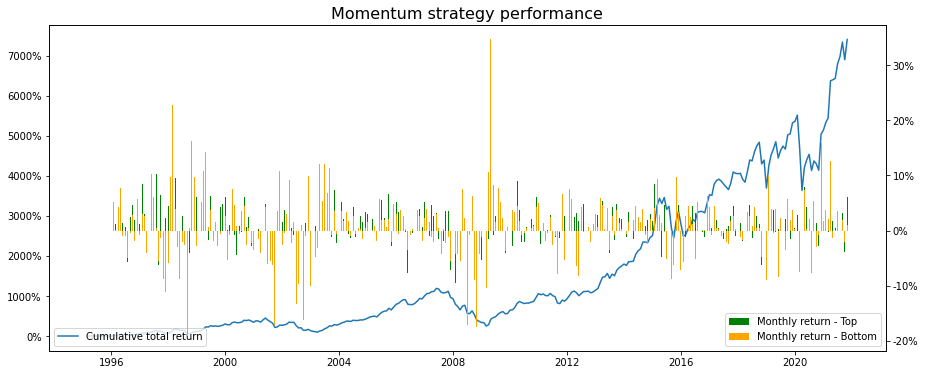

In [1220]:
# Plot strategy cumulative performance on primary axis
fig, ax1 = plt.subplots(figsize=(15,6))
ax1.plot(backtest_HRP.index, backtest_HRP['Cumulative total return']) 
ax1.grid(False)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax1.legend(['Cumulative total return'], loc='lower left')

# Plot monthly Long and Short returns on secondary axis
ax2 = ax1.twinx()
ax2.bar(backtest_HRP.index, backtest_HRP['Monthly return - Top'], width=12, alpha=1, color='green')
ax2.bar(backtest_HRP.index, backtest_HRP['Monthly return - Bottom'], width=12, alpha=1, color='orange')
ax2.grid(False)
ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y))) 
ax2.legend(['Monthly return - Top','Monthly return - Bottom'], loc='lower right')

plt.title('Momentum strategy performance', fontsize=16)
plt.show()

In [1221]:
# Get annualized performance and volatility results of momentum strategy
holding_months = np.count_nonzero(backtest_HRP['Selected stocks']) # no -1 as no stock data for October 2021 by dataframe construction
# Calculate annualized return of Long, Short, and overall Long/Short strategy
table = [['Top', round(100*((1 + backtest_HRP['Cumulative Top return'][-1])**(12/holding_months)-1),2), round(100*(np.std(backtest_HRP['Monthly return - Top']) * np.sqrt(12)),2), \
            round(((1 + backtest_HRP['Cumulative Top return'][-1])**(12/holding_months)-1)/(np.std(backtest_HRP['Monthly return - Top']) * np.sqrt(12)),2)], \
            ['Bottom', round(100*((1 + backtest_HRP['Cumulative Bottom return'][-1])**(12/holding_months)-1),2), round(100*(np.std(backtest_HRP['Monthly return - Bottom']) * np.sqrt(12)),2), \
            round(((1 + backtest_HRP['Cumulative Bottom return'][-1])**(12/holding_months)-1)/(np.std(backtest_HRP['Monthly return - Bottom']) * np.sqrt(12)),2)], \
            ['Total (Top+Bottom)', round(100*((1 + backtest_HRP['Cumulative total return'][-1])**(12/holding_months)-1),2), round(100*(np.std(backtest_HRP['Monthly total return']) * np.sqrt(12)),2), \
            round(((1 + backtest_HRP['Cumulative total return'][-1])**(12/holding_months)-1)/(np.std(backtest_HRP['Monthly total return']) * np.sqrt(12)),2)]]
header = ['Strategy','Annualized return (in %)','Annualized volatility (in %)', 'Return over risk ratio']
print(tabulate(table,headers=header))

Strategy              Annualized return (in %)    Annualized volatility (in %)    Return over risk ratio
------------------  --------------------------  ------------------------------  ------------------------
Top                                      11.42                           12.19                      0.94
Bottom                                    7.78                           19.28                      0.4
Total (Top+Bottom)                       18.2                            28.24                      0.64


**CONCLUSION**:
- Moving from naive strategy (equal weights) to portfolio allocation with HRP portfolio optimization generates a much better return over risk ratio than the naive long/long 12-1 momentum strategy, as the ratio increased from 0.53 to 0.64. 
- The annual performance of 18% is very solid, to the detriment of the high volatility of 28%
- Allocating weights generates twice more returns than the naive long/long 12-1 momentum strategy (18.2% against 9.02%), but it also generates more volatility (28.24% instead of 17.11%)

**Alternative ideas**:
- Use HRP portfolio optimization on long/long 12-1 momentum strategy derived from risk-adjusted returns

## Alternative ideas

### Example of hierarchical clustering

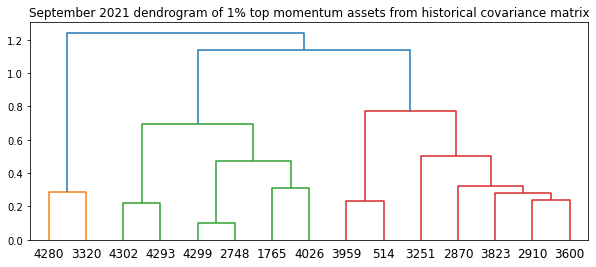

In [1242]:
# Get 1% TOP assets from 12-1 long/short momentum strategy
top_assets_1 = mom_strategy(df,12,0.01,'Long','Short').get_stocks('top','identifiers')
bottom_assets_1 = mom_strategy(df,12,0.01,'Long','Short').get_stocks('bottom','identifiers')
# Get dataframe of 12 past monthly returns as of September 2021
returns_1 = get_returns_df(top_assets_1,12,320)
# Estimate correlations of underlying assets
corrMatrix = returns_1.corr()
# Estimate the dendogram of underlying assets
plt.figure(figsize=(10, 4))  
plt.title('September 2021 dendrogram of 1% top momentum assets from historical covariance matrix')  
z_historical = sch.linkage(corrMatrix.values, method='average', metric='correlation')
dendrogram_historical = sch.dendrogram(z_historical, labels=corrMatrix.columns)  
plt.show()

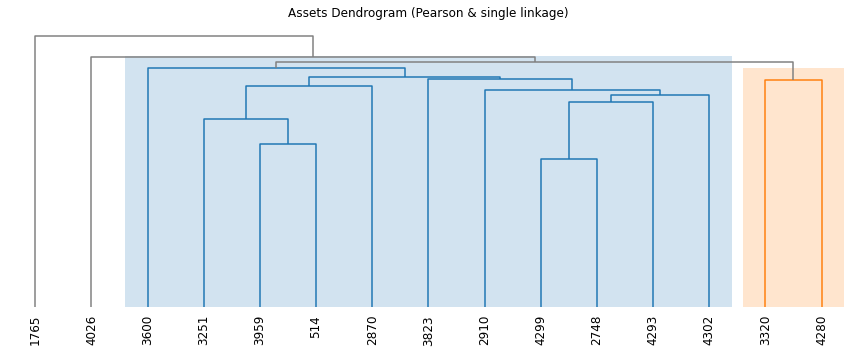

In [1238]:
ax = rp.plot_dendrogram(returns=returns_1,
                        codependence='pearson',
                        linkage='single',
                        k=None,
                        max_k=10,
                        leaf_order=True,
                        ax=None)

# Conclusion

- There is momentum in financial markets, particularly on rising stocks.
- Long-only portfolios generate more returns and higher return-over-risk ratios than traditional long-short approach.
- Best strategy for risk-adverse investors: 12-1 long-only momentum derived from risk-adjusted returns; highest return-over-risk ratio among all strategies, with lowest volatility among all long-only strategies.
- Best strategy for investors looking for performance: 12-1 long-only HRP weight allocation; High performance, high volatility, and aligned return-over-risk ratio than 12-1 long-only momentum strategy derived from risk-adjusted returns.